# Wavefront Set Neural Network - U-Net Training

This notebook trains a U-Net to predict wavefront set angles from shape boundaries.

**Make sure to enable GPU:** Runtime → Change runtime type → Hardware accelerator → GPU

## 1. Install Dependencies and Setup

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 2. Data Generation Functions

In [27]:
# Constants
K = 36  # Number of angle bins
bin_width = np.pi / K

def generate_circle_normals(H, W, seed=None):
    """Generate a circle and return angles at boundary pixels"""
    rng = np.random.default_rng(seed)
    center_x = rng.uniform(0.2 * W, 0.8 * W)
    center_y = rng.uniform(0.2 * H, 0.8 * H)
    radius = rng.uniform(0.15 * min(H, W), 0.35 * min(H, W))

    y, x = np.ogrid[:H, :W]
    mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2

    # Detect boundary pixels
    boundary = mask & ~binary_erosion(mask)

    angles = np.zeros((H, W), dtype=np.float32)
    for i in range(H):
        for j in range(W):
            if boundary[i, j]:
                dx = j - center_x
                dy = i - center_y
                length = np.sqrt(dx ** 2 + dy ** 2)
                if length > 0:
                    angle = np.arctan2(dy, dx)
                    angles[i, j] = angle % np.pi

    return angles, mask

def generate_polygon_normals(H, W, num_vertices=5, seed=None):
    rng = np.random.default_rng(seed)
    center_x = rng.uniform(0.3 * W, 0.7 * W)
    center_y = rng.uniform(0.3 * H, 0.7 * H)
    radii = rng.uniform(0.2 * min(H, W), 0.4 * min(H, W), size=num_vertices)
    angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
    angles += rng.uniform(0, 2 * np.pi / num_vertices, size=num_vertices)

    vertices = np.array([
        (center_x + radii[i] * np.cos(angle), center_y + radii[i] * np.sin(angle))
        for i, angle in enumerate(angles)
    ])

    from matplotlib.path import Path
    poly_path = Path(vertices)

    y, x = np.mgrid[:H, :W]
    points = np.vstack((x.ravel(), y.ravel())).T
    mask = poly_path.contains_points(points).reshape(H, W)

    # Detect boundary pixels (inside mask with at least one neighbor outside)

    boundary = mask & ~binary_erosion(mask)

    angles = np.zeros((H, W), dtype=np.float32)
    for i in range(H):
        for j in range(W):
            if boundary[i, j]:
                closest_dist = float('inf')
                closest_normal = (0, 0)
                for v1, v2 in zip(vertices, np.roll(vertices, -1, axis=0)):
                    edge_vec = v2 - v1
                    edge_length = np.linalg.norm(edge_vec)
                    if edge_length == 0:
                        continue
                    edge_dir = edge_vec / edge_length
                    normal_vec = np.array([-edge_dir[1], edge_dir[0]])

                    point_vec = np.array([j - v1[0], i - v1[1]])
                    proj_length = np.dot(point_vec, edge_dir)
                    if proj_length < 0:
                        closest_point = v1
                    elif proj_length > edge_length:
                        closest_point = v2
                    else:
                        closest_point = v1 + proj_length * edge_dir

                    dist = np.linalg.norm(np.array([j, i]) - closest_point)
                    if dist < closest_dist:
                        closest_dist = dist
                        closest_normal = normal_vec

                length = np.linalg.norm(closest_normal)
                if length > 0:
                    # Compute angle in [0, pi) for outward normal
                    angle = np.arctan2(closest_normal[1], closest_normal[0])
                    # Map to [0, pi) by taking the angle modulo pi
                    # This keeps the direction information without flipping
                    angles[i, j] = angle % np.pi

    return angles, mask

def generate_ellipse_normals(H, W, seed=None):
    rng = np.random.default_rng(seed)
    center_x = rng.uniform(0.2 * W, 0.8 * W)
    center_y = rng.uniform(0.2 * H, 0.8 * H)
    min_dim = min(H, W)
    a = rng.uniform(0.15 * min_dim, 0.35 * min_dim)  # Semi-major axis
    b = rng.uniform(0.15 * min_dim, 0.35 * min_dim)  # Semi-minor axis
    rotation = rng.uniform(0, 2 * np.pi)

    y, x = np.mgrid[:H, :W]

    # Transform to local coordinates centered and unrotated
    cos_r = np.cos(rotation)
    sin_r = np.sin(rotation)
    dx = x - center_x
    dy = y - center_y

    local_x = dx * cos_r + dy * sin_r
    local_y = -dx * sin_r + dy * cos_r

    mask = (local_x / a)**2 + (local_y / b)**2 <= 1
    boundary = mask & ~binary_erosion(mask)

    angles = np.zeros((H, W), dtype=np.float32)

    # For ellipses, normal is not just radial
    # Gradient of F(x,y) = (x'/a)^2 + (y'/b)^2 = 1
    # Local normal (unnormalized): (x'/a^2, y'/b^2)

    y_idxs, x_idxs = np.where(boundary)
    if len(y_idxs) > 0:
        lx = local_x[boundary]
        ly = local_y[boundary]

        # Local normal components
        nx_local = lx / (a**2)
        ny_local = ly / (b**2)

        # Rotate normal back to global coordinates
        # The normal vector rotates same as the shape
        nx = nx_local * cos_r - ny_local * sin_r
        ny = nx_local * sin_r + ny_local * cos_r

        calc_angles = np.arctan2(ny, nx)
        angles[boundary] = calc_angles % np.pi

    return angles, mask

print("Data generation functions loaded!")

Data generation functions loaded!


## 3. Generate Training Data

In [14]:
# Training data parameters
num_samples = 1000
H, W = 128, 128  # Good balance for Colab

print(f"Generating {num_samples} training samples ({H}x{W})...")

masks = []
angles = []

for i in range(num_samples):
    if (i + 1) % 100 == 0:
        print(f"  Generated {i + 1}/{num_samples} samples")

    # Train only on Circles and Polygons to test generalization later
    if i % 2 == 0:
        angle_map, mask = generate_circle_normals(H, W, seed=i)
    else:
        rng = np.random.default_rng(i)
        nv = rng.integers(3, 9)
        angle_map, mask = generate_polygon_normals(H, W, num_vertices=nv, seed=i)

    masks.append(mask)
    angles.append(angle_map)

masks_tensor = torch.tensor(np.array(masks), dtype=torch.float32)
angles_tensor = torch.tensor(np.array(angles), dtype=torch.float32)

print(f"\nDataset created!")
print(f"  Samples: {len(masks)}")
print(f"  Image size: {H}x{W}")
print(f"  Avg boundary pixels: {torch.mean(torch.sum(angles_tensor > 0, dim=(1, 2)).float()):.1f}")

Generating 1000 training samples (128x128)...
  Generated 100/1000 samples
  Generated 200/1000 samples
  Generated 300/1000 samples
  Generated 400/1000 samples
  Generated 500/1000 samples
  Generated 600/1000 samples
  Generated 700/1000 samples
  Generated 800/1000 samples
  Generated 900/1000 samples
  Generated 1000/1000 samples

Dataset created!
  Samples: 1000
  Image size: 128x128
  Avg boundary pixels: 188.3


## 4. U-Net Model Definition

In [15]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                          diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class WavefrontUNet(nn.Module):
    def __init__(self, K=36, bilinear=False):
        super(WavefrontUNet, self).__init__()
        self.unet = UNet(n_channels=1, n_classes=K, bilinear=bilinear)
        self.K = K

    def forward(self, x):
        return self.unet(x)

print("U-Net model defined!")

U-Net model defined!


## 5. Dataset and DataLoader

In [16]:
def angle_to_bin(angle, K):
    bin_width = np.pi / K
    bin_idx = int(angle / bin_width)
    return min(bin_idx, K-1)

class WavefrontDataset(Dataset):
    def __init__(self, masks, angles, K):
        self.masks = masks
        self.angles = angles
        self.K = K

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        mask = self.masks[idx].unsqueeze(0)
        angles = self.angles[idx]
        H, W = angles.shape

        target = torch.zeros((H, W), dtype=torch.long)
        boundary_mask = angles > 0

        # Vectorized conversion
        boundary_angles = angles[boundary_mask]
        if len(boundary_angles) > 0:
            bins = (boundary_angles / (np.pi / self.K)).long()
            bins = torch.clamp(bins, 0, self.K - 1)
            target[boundary_mask] = bins

        return mask, target, boundary_mask.float()

# Create dataset and split
dataset = WavefrontDataset(masks_tensor, angles_tensor, K)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Train samples: {train_size}, Val samples: {val_size}")

Train samples: 800, Val samples: 200


## 6. Training Functions

In [17]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets, masks in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        batch_size, K, H, W = outputs.shape
        outputs_flat = outputs.permute(0, 2, 3, 1).reshape(-1, K)
        targets_flat = targets.reshape(-1)
        masks_flat = masks.reshape(-1)

        loss = criterion(outputs_flat, targets_flat)
        loss = (loss * masks_flat).sum() / (masks_flat.sum() + 1e-8)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs_flat, 1)
        boundary_pixels = masks_flat > 0
        if boundary_pixels.sum() > 0:
            correct += (predicted[boundary_pixels] == targets_flat[boundary_pixels]).sum().item()
            total += boundary_pixels.sum().item()

    accuracy = 100 * correct / total if total > 0 else 0
    return running_loss / len(dataloader), accuracy

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets, masks in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            outputs = model(inputs)

            batch_size, K, H, W = outputs.shape
            outputs_flat = outputs.permute(0, 2, 3, 1).reshape(-1, K)
            targets_flat = targets.reshape(-1)
            masks_flat = masks.reshape(-1)

            loss = criterion(outputs_flat, targets_flat)
            loss = (loss * masks_flat).sum() / (masks_flat.sum() + 1e-8)

            running_loss += loss.item()

            _, predicted = torch.max(outputs_flat, 1)
            boundary_pixels = masks_flat > 0
            if boundary_pixels.sum() > 0:
                correct += (predicted[boundary_pixels] == targets_flat[boundary_pixels]).sum().item()
                total += boundary_pixels.sum().item()

    accuracy = 100 * correct / total if total > 0 else 0
    return running_loss / len(dataloader), accuracy

print("Training functions defined!")

Training functions defined!


## 7. Train the Model

In [18]:
# Create model
model = WavefrontUNet(K=K, bilinear=False)
model = model.to(device)
print(f"Model: {sum(p.numel() for p in model.parameters())} parameters\n")

# Training setup
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop
num_epochs = 30
best_val_loss = float('inf')
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting training...\n")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.1f}% | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.1f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_wavefront_unet.pth')
        print("  ✓ Saved best model")

print(f"\nTraining complete! Best val loss: {best_val_loss:.4f}")

Model: 31038756 parameters

Starting training...

Epoch 1/30: Train Loss=2.0823, Acc=30.9% | Val Loss=1.6232, Acc=44.8%
  ✓ Saved best model
Epoch 2/30: Train Loss=1.1362, Acc=54.8% | Val Loss=1.0182, Acc=59.9%
  ✓ Saved best model
Epoch 3/30: Train Loss=0.9130, Acc=63.8% | Val Loss=0.8724, Acc=65.6%
  ✓ Saved best model
Epoch 4/30: Train Loss=0.8421, Acc=66.2% | Val Loss=0.8522, Acc=65.8%
  ✓ Saved best model
Epoch 5/30: Train Loss=0.7534, Acc=70.0% | Val Loss=0.7498, Acc=70.4%
  ✓ Saved best model
Epoch 6/30: Train Loss=0.7389, Acc=70.7% | Val Loss=0.7968, Acc=69.5%
Epoch 7/30: Train Loss=0.7110, Acc=71.5% | Val Loss=0.7351, Acc=71.1%
  ✓ Saved best model
Epoch 8/30: Train Loss=0.6557, Acc=74.2% | Val Loss=0.6852, Acc=73.5%
  ✓ Saved best model
Epoch 9/30: Train Loss=0.6354, Acc=74.4% | Val Loss=0.6672, Acc=73.2%
  ✓ Saved best model
Epoch 10/30: Train Loss=0.5911, Acc=76.7% | Val Loss=0.7044, Acc=72.1%
Epoch 11/30: Train Loss=0.6029, Acc=76.0% | Val Loss=0.6615, Acc=73.9%
  ✓ Saved 

## 8. Plot Training History

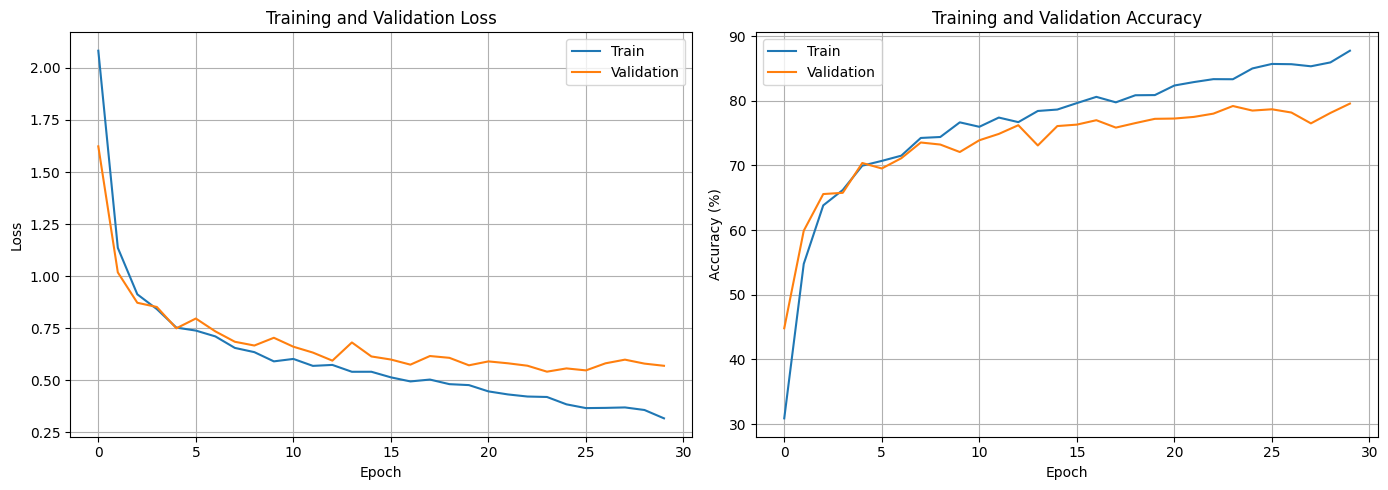

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_loss'], label='Train')
ax1.plot(history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['val_acc'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 9b. Test Predictions for Polygon

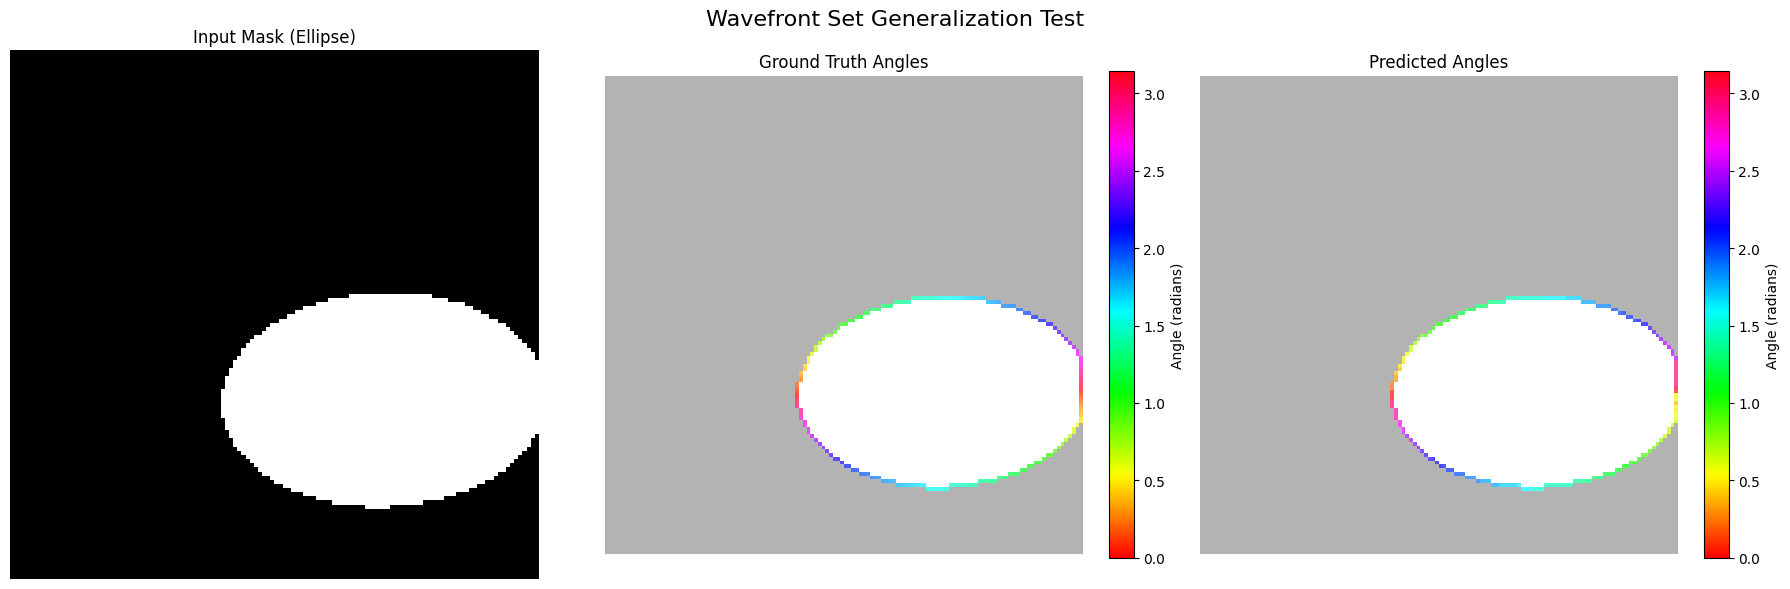


Mean Absolute Error: 0.0400 radians (2.29 degrees)


In [28]:
# Load best model
model.load_state_dict(torch.load('best_wavefront_unet.pth'))
model.eval()

# Generate test samples - Test Generalization on Ellipse
test_angles, test_mask = generate_ellipse_normals(H, W, seed=9999)

# Predict
with torch.no_grad():
    mask_tensor = torch.tensor(test_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    outputs = model(mask_tensor)
    predicted_bins = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()
    predicted_angles = predicted_bins * bin_width + bin_width / 2

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(test_mask, cmap='gray')
axes[0].set_title('Input Mask (Ellipse)')
axes[0].axis('off')

gt_masked = np.ma.masked_where(test_angles == 0, test_angles)
im1 = axes[1].imshow(gt_masked, cmap='hsv', vmin=0, vmax=np.pi)
axes[1].imshow(test_mask, cmap='gray', alpha=0.3)
axes[1].set_title('Ground Truth Angles')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, label='Angle (radians)')

# Calculate boundary for better visualization
boundary = test_mask & ~binary_erosion(test_mask)
pred_masked = np.ma.masked_where(~boundary, predicted_angles)

im2 = axes[2].imshow(pred_masked, cmap='hsv', vmin=0, vmax=np.pi)
axes[2].imshow(test_mask, cmap='gray', alpha=0.3)
axes[2].set_title('Predicted Angles')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, label='Angle (radians)')

plt.suptitle('Wavefront Set Generalization Test', fontsize=16)
plt.tight_layout()
plt.show()

# Compute metrics
boundary_mask = test_angles > 0
if boundary_mask.sum() > 0:
    gt_boundary = test_angles[boundary_mask]
    pred_boundary = predicted_angles[boundary_mask]
    mae = np.mean(np.abs(gt_boundary - pred_boundary))
    print(f"\nMean Absolute Error: {mae:.4f} radians ({mae * 180 / np.pi:.2f} degrees)")

In [29]:
# Evaluate on a batch of Ellipses
num_test = 200
print(f"Generating {num_test} ellipse samples for evaluation...")

test_masks = []
test_angles = []

# Generate data
for i in range(num_test):
    # Use a seed offset to ensure new shapes
    angle_map, mask = generate_ellipse_normals(H, W, seed=10000+i)
    test_masks.append(mask)
    test_angles.append(angle_map)

# Convert to tensors
test_masks_tensor = torch.tensor(np.array(test_masks), dtype=torch.float32)
test_angles_tensor = torch.tensor(np.array(test_angles), dtype=torch.float32)

# Create DataLoader
test_dataset = WavefrontDataset(test_masks_tensor, test_angles_tensor, K)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation Loop
model.eval()
all_maes = []
total_correct = 0
total_pixels = 0

print("Running evaluation...")

with torch.no_grad():
    for inputs, targets, masks in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        masks = masks.to(device)

        outputs = model(inputs)
        _, predicted_bins = torch.max(outputs, 1)

        # Filter for boundary pixels only
        boundary_mask = masks > 0

        if boundary_mask.sum() > 0:
            # 1. Calculate Accuracy (Bin Match)
            total_correct += (predicted_bins[boundary_mask] == targets[boundary_mask]).sum().item()
            total_pixels += boundary_mask.sum().item()

            # 2. Calculate MAE (Angular Error)
            # Convert bins to angles (center of bin)
            pred_angles = predicted_bins.float() * bin_width + bin_width/2
            gt_angles = targets.float() * bin_width + bin_width/2

            # Calculate difference
            diff = torch.abs(pred_angles - gt_angles)

            # Handle circular wrapping: 0 and pi are the same orientation
            # The minimum distance is min(|a-b|, pi - |a-b|)
            diff = torch.min(diff, np.pi - diff)

            # Store errors for boundary pixels
            all_maes.extend(diff[boundary_mask].cpu().numpy())

# Compute aggregate metrics
accuracy = 100 * total_correct / total_pixels if total_pixels > 0 else 0
mean_mae = np.mean(all_maes)

print(f"\nResults on {num_test} Ellipses:")
print(f"  Pixel Accuracy: {accuracy:.2f}%")
print(f"  Mean Absolute Error: {mean_mae:.4f} radians ({np.degrees(mean_mae):.2f} degrees)")

Generating 200 ellipse samples for evaluation...
Running evaluation...

Results on 200 Ellipses:
  Pixel Accuracy: 79.57%
  Mean Absolute Error: 0.0242 radians (1.39 degrees)


## 10. Download Trained Model

Run this cell to download the trained model to your computer.

In [21]:
from google.colab import files
files.download('best_wavefront_unet.pth')
print("Model downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded!


# Task
Modify the `generate_polygon_normals`, `generate_circle_normals`, and `generate_ellipse_normals` functions to return an `angles` array of shape `(H, W, 2)` instead of `(H, W)`.

For `generate_polygon_normals`:
1.  Identify boundary pixels that are close to a polygon vertex.
2.  For vertex pixels, store the normal angles of both adjacent edges in the two channels of the `angles` array.
3.  For non-vertex boundary pixels, store the edge normal in channel 0 and use a sentinel value (e.g., -100) in channel 1.

For `generate_circle_normals` and `generate_ellipse_normals`:
1.  Store the calculated angle in channel 0 and the sentinel value (e.g., -100) in channel 1.

Ensure all valid angles are in the range `[0, pi)`. Do not regenerate the dataset yet.

## Update Data Generation for Corners

### Subtask:
Modify data generation functions to return (H, W, 2) angle arrays, enabling storage of multiple normals at corners.


**Reasoning**:
Update the data generation functions `generate_circle_normals`, `generate_ellipse_normals`, and `generate_polygon_normals` to return an `(H, W, 2)` array for angles. This allows storing multiple normals at corners (specifically for polygons) while using a sentinel value (-100.0) for unused slots.



In [30]:
def generate_circle_normals(H, W, seed=None):
    """Generate a circle and return angles at boundary pixels (H, W, 2)"""
    rng = np.random.default_rng(seed)
    center_x = rng.uniform(0.2 * W, 0.8 * W)
    center_y = rng.uniform(0.2 * H, 0.8 * H)
    radius = rng.uniform(0.15 * min(H, W), 0.35 * min(H, W))

    y, x = np.ogrid[:H, :W]
    mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2

    # Detect boundary pixels
    boundary = mask & ~binary_erosion(mask)

    # Initialize with sentinel value
    angles = np.full((H, W, 2), -100.0, dtype=np.float32)

    for i in range(H):
        for j in range(W):
            if boundary[i, j]:
                dx = j - center_x
                dy = i - center_y
                length = np.sqrt(dx ** 2 + dy ** 2)
                if length > 0:
                    angle = np.arctan2(dy, dx)
                    # Store in channel 0
                    angles[i, j, 0] = angle % np.pi

    return angles, mask

def generate_ellipse_normals(H, W, seed=None):
    rng = np.random.default_rng(seed)
    center_x = rng.uniform(0.2 * W, 0.8 * W)
    center_y = rng.uniform(0.2 * H, 0.8 * H)
    min_dim = min(H, W)
    a = rng.uniform(0.15 * min_dim, 0.35 * min_dim)  # Semi-major axis
    b = rng.uniform(0.15 * min_dim, 0.35 * min_dim)  # Semi-minor axis
    rotation = rng.uniform(0, 2 * np.pi)

    y, x = np.mgrid[:H, :W]

    # Transform to local coordinates centered and unrotated
    cos_r = np.cos(rotation)
    sin_r = np.sin(rotation)
    dx = x - center_x
    dy = y - center_y

    local_x = dx * cos_r + dy * sin_r
    local_y = -dx * sin_r + dy * cos_r

    mask = (local_x / a)**2 + (local_y / b)**2 <= 1
    boundary = mask & ~binary_erosion(mask)

    angles = np.full((H, W, 2), -100.0, dtype=np.float32)

    # For ellipses, normal is not just radial
    y_idxs, x_idxs = np.where(boundary)
    if len(y_idxs) > 0:
        lx = local_x[boundary]
        ly = local_y[boundary]

        # Local normal components
        nx_local = lx / (a**2)
        ny_local = ly / (b**2)

        # Rotate normal back to global coordinates
        nx = nx_local * cos_r - ny_local * sin_r
        ny = nx_local * sin_r + ny_local * cos_r

        calc_angles = np.arctan2(ny, nx)
        angles[boundary, 0] = calc_angles % np.pi

    return angles, mask

def generate_polygon_normals(H, W, num_vertices=5, seed=None):
    rng = np.random.default_rng(seed)
    center_x = rng.uniform(0.3 * W, 0.7 * W)
    center_y = rng.uniform(0.3 * H, 0.7 * H)
    radii = rng.uniform(0.2 * min(H, W), 0.4 * min(H, W), size=num_vertices)
    angles_gen = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
    angles_gen += rng.uniform(0, 2 * np.pi / num_vertices, size=num_vertices)

    vertices = np.array([
        (center_x + radii[i] * np.cos(angle), center_y + radii[i] * np.sin(angle))
        for i, angle in enumerate(angles_gen)
    ])

    from matplotlib.path import Path
    poly_path = Path(vertices)

    y, x = np.mgrid[:H, :W]
    points = np.vstack((x.ravel(), y.ravel())).T
    mask = poly_path.contains_points(points).reshape(H, W)
    boundary = mask & ~binary_erosion(mask)

    angles = np.full((H, W, 2), -100.0, dtype=np.float32)

    # Pre-calculate normals for all edges
    # Edge i connects vertex i to vertex (i+1)%N
    edge_normals = []
    for k in range(num_vertices):
        v1 = vertices[k]
        v2 = vertices[(k + 1) % num_vertices]
        edge_vec = v2 - v1
        edge_length = np.linalg.norm(edge_vec)
        if edge_length > 0:
            edge_dir = edge_vec / edge_length
            # Outward normal (assuming CCW winding usually produced by angular sort)
            normal_vec = np.array([-edge_dir[1], edge_dir[0]])
        else:
            normal_vec = np.zeros(2)
        edge_normals.append(normal_vec)

    for i in range(H):
        for j in range(W):
            if boundary[i, j]:
                point = np.array([j, i])

                # Check for corner (closeness to vertex)
                dists = np.linalg.norm(vertices - point, axis=1)
                min_dist_idx = np.argmin(dists)

                if dists[min_dist_idx] < 2.0:
                    # It's a corner! Get normals of adjacent edges.
                    # Vertex k connects Edge k-1 (incoming) and Edge k (outgoing)
                    idx_prev = (min_dist_idx - 1) % num_vertices
                    idx_curr = min_dist_idx

                    n1 = edge_normals[idx_prev]
                    n2 = edge_normals[idx_curr]

                    if np.linalg.norm(n1) > 0:
                        angles[i, j, 0] = np.arctan2(n1[1], n1[0]) % np.pi
                    if np.linalg.norm(n2) > 0:
                        angles[i, j, 1] = np.arctan2(n2[1], n2[0]) % np.pi

                else:
                    # Not a corner, find single closest edge
                    closest_dist = float('inf')
                    closest_normal = (0, 0)

                    for k in range(num_vertices):
                        v1 = vertices[k]
                        v2 = vertices[(k + 1) % num_vertices]
                        edge_vec = v2 - v1
                        edge_length = np.linalg.norm(edge_vec)
                        if edge_length == 0: continue

                        edge_dir = edge_vec / edge_length
                        point_vec = point - v1
                        proj_length = np.dot(point_vec, edge_dir)

                        if proj_length < 0:
                            closest_point = v1
                        elif proj_length > edge_length:
                            closest_point = v2
                        else:
                            closest_point = v1 + proj_length * edge_dir

                        dist = np.linalg.norm(point - closest_point)
                        if dist < closest_dist:
                            closest_dist = dist
                            closest_normal = edge_normals[k]

                    length = np.linalg.norm(closest_normal)
                    if length > 0:
                        angle = np.arctan2(closest_normal[1], closest_normal[0])
                        angles[i, j, 0] = angle % np.pi

    return angles, mask

print("Data generation functions updated for multi-normal corners!")

Data generation functions updated for multi-normal corners!


## Modify Dataset for Multi-Label Targets

### Subtask:
Regenerate the dataset with the updated functions and modify the `WavefrontDataset` class to produce multi-hot encoded targets for BCE loss.


**Reasoning**:
Regenerate the dataset using the updated functions and redefine the `WavefrontDataset` class to produce multi-hot targets suitable for multi-label classification (e.g., corners). Then, re-initialize the DataLoaders.



In [31]:
# 1. Regenerate Training Data
print(f"Regenerating {num_samples} training samples with multi-label support...")

masks = []
angles = []

for i in range(num_samples):
    if (i + 1) % 100 == 0:
        print(f"  Generated {i + 1}/{num_samples} samples")

    if i % 2 == 0:
        angle_map, mask = generate_circle_normals(H, W, seed=i)
    else:
        rng = np.random.default_rng(i)
        nv = rng.integers(3, 9)
        angle_map, mask = generate_polygon_normals(H, W, num_vertices=nv, seed=i)

    masks.append(mask)
    angles.append(angle_map)

masks_tensor = torch.tensor(np.array(masks), dtype=torch.float32)
angles_tensor = torch.tensor(np.array(angles), dtype=torch.float32)

print(f"\nNew Dataset Created!")
print(f"  Masks shape: {masks_tensor.shape}")
print(f"  Angles shape: {angles_tensor.shape}")

# 2. Redefine WavefrontDataset for Multi-Label Targets
class WavefrontDataset(Dataset):
    def __init__(self, masks, angles, K):
        self.masks = masks
        self.angles = angles
        self.K = K
        self.bin_width = np.pi / K

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        mask = self.masks[idx].unsqueeze(0)  # (1, H, W)
        angle_map = self.angles[idx]         # (H, W, 2)
        H, W, C = angle_map.shape

        # Target shape: (K, H, W) for multi-hot encoding
        target = torch.zeros((self.K, H, W), dtype=torch.float32)

        # Identify boundary pixels (any valid angle)
        # Sentinel is -100, so check > -10
        valid_mask = angle_map > -10.0

        # Create boundary mask for loss weighting (1, H, W)
        # A pixel is on boundary if either channel has a valid angle
        boundary_mask = (valid_mask[..., 0] | valid_mask[..., 1]).float().unsqueeze(0)

        # Fill targets
        # Iterate over the two channels (0 and 1)
        for c in range(2):
            # Get valid angles for this channel
            channel_valid = valid_mask[..., c]
            if channel_valid.any():
                vals = angle_map[..., c][channel_valid]

                # Convert to bins
                bins = (vals / self.bin_width).long()
                bins = torch.clamp(bins, 0, self.K - 1)

                # Get indices
                y_idxs, x_idxs = torch.where(channel_valid)

                # Set 1.0 in the corresponding bin channel
                target[bins, y_idxs, x_idxs] = 1.0

        return mask, target, boundary_mask

# 3. Instantiate and Split
dataset = WavefrontDataset(masks_tensor, angles_tensor, K)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# 4. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Train samples: {train_size}, Val samples: {val_size}")

# Check one sample
sample_mask, sample_target, sample_boundary = train_dataset[0]
print(f"Sample target shape: {sample_target.shape}")
print(f"Sample max values per pixel: {sample_target.sum(dim=0).max().item()} (should be 2.0 for corners)")

Regenerating 1000 training samples with multi-label support...
  Generated 100/1000 samples
  Generated 200/1000 samples
  Generated 300/1000 samples
  Generated 400/1000 samples
  Generated 500/1000 samples
  Generated 600/1000 samples
  Generated 700/1000 samples
  Generated 800/1000 samples
  Generated 900/1000 samples
  Generated 1000/1000 samples

New Dataset Created!
  Masks shape: torch.Size([1000, 128, 128])
  Angles shape: torch.Size([1000, 128, 128, 2])
Train samples: 800, Val samples: 200
Sample target shape: torch.Size([36, 128, 128])
Sample max values per pixel: 1.0 (should be 2.0 for corners)


## Train with BCEWithLogitsLoss

### Subtask:
Define the training functions using BCEWithLogitsLoss and retrain the U-Net model on the multi-label dataset.


**Reasoning**:
Define the training and validation functions adapted for multi-label classification using BCEWithLogitsLoss.



In [32]:
def train_epoch_multilabel(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets, masks in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # BCEWithLogitsLoss returns (B, K, H, W)
        loss_map = criterion(outputs, targets)
        # Mask out non-boundary pixels
        # Sum loss over all bins and all boundary pixels
        # Divide by number of boundary pixels to get average total BCE per pixel
        loss = (loss_map * masks).sum() / (masks.sum() + 1e-8)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Top-1 Accuracy Check
        # Get the predicted bin (highest logit)
        pred_bins = torch.argmax(outputs, dim=1, keepdim=True)
        # Check if the target has a 1.0 at this bin
        is_correct = torch.gather(targets, 1, pred_bins)

        # Only evaluate on boundary pixels
        boundary_mask = masks > 0
        if boundary_mask.sum() > 0:
            correct += (is_correct[boundary_mask] > 0.5).sum().item()
            total += boundary_mask.sum().item()

    accuracy = 100 * correct / total if total > 0 else 0
    return running_loss / len(dataloader), accuracy

def validate_multilabel(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets, masks in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            outputs = model(inputs)
            loss_map = criterion(outputs, targets)
            loss = (loss_map * masks).sum() / (masks.sum() + 1e-8)

            running_loss += loss.item()

            pred_bins = torch.argmax(outputs, dim=1, keepdim=True)
            is_correct = torch.gather(targets, 1, pred_bins)

            boundary_mask = masks > 0
            if boundary_mask.sum() > 0:
                correct += (is_correct[boundary_mask] > 0.5).sum().item()
                total += boundary_mask.sum().item()

    accuracy = 100 * correct / total if total > 0 else 0
    return running_loss / len(dataloader), accuracy

print("Multi-label training functions defined.")

Multi-label training functions defined.


**Reasoning**:
Re-initialize the model, optimizer, and loss function, then run the training loop for 30 epochs using the multi-label training functions defined in the previous step. This fulfills instructions 2 and 3.



In [33]:
# Re-initialize model
model = WavefrontUNet(K=K, bilinear=False).to(device)
print(f"Model re-initialized for multi-label training.")

# Optimizer and Criterion
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(reduction='none')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training Loop
num_epochs = 30
best_val_loss = float('inf')
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting multi-label training...\n")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_multilabel(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_multilabel(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.1f}% | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.1f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_multilabel_unet.pth')
        print("  ✓ Saved best model")

print(f"\nTraining complete! Best val loss: {best_val_loss:.4f}")

Model re-initialized for multi-label training.
Starting multi-label training...

Epoch 1/30: Train Loss=5.6564, Acc=15.0% | Val Loss=4.9523, Acc=25.2%
  ✓ Saved best model
Epoch 2/30: Train Loss=2.8187, Acc=38.3% | Val Loss=2.6129, Acc=45.2%
  ✓ Saved best model
Epoch 3/30: Train Loss=2.3472, Acc=50.4% | Val Loss=2.2036, Acc=54.3%
  ✓ Saved best model
Epoch 4/30: Train Loss=2.0959, Acc=57.8% | Val Loss=2.0798, Acc=56.9%
  ✓ Saved best model
Epoch 5/30: Train Loss=1.8856, Acc=64.1% | Val Loss=1.9252, Acc=61.6%
  ✓ Saved best model
Epoch 6/30: Train Loss=1.7835, Acc=65.5% | Val Loss=1.7722, Acc=64.9%
  ✓ Saved best model
Epoch 7/30: Train Loss=1.6614, Acc=68.5% | Val Loss=1.5867, Acc=71.5%
  ✓ Saved best model
Epoch 8/30: Train Loss=1.5881, Acc=70.3% | Val Loss=1.5448, Acc=71.2%
  ✓ Saved best model
Epoch 9/30: Train Loss=1.5084, Acc=71.9% | Val Loss=1.5869, Acc=69.0%
Epoch 10/30: Train Loss=1.4604, Acc=72.8% | Val Loss=1.6193, Acc=68.2%
Epoch 11/30: Train Loss=1.4428, Acc=73.2% | Val Lo

**Reasoning**:
Plot the training and validation loss and accuracy curves to visualize the model's performance over epochs, as per the final instruction of the subtask.



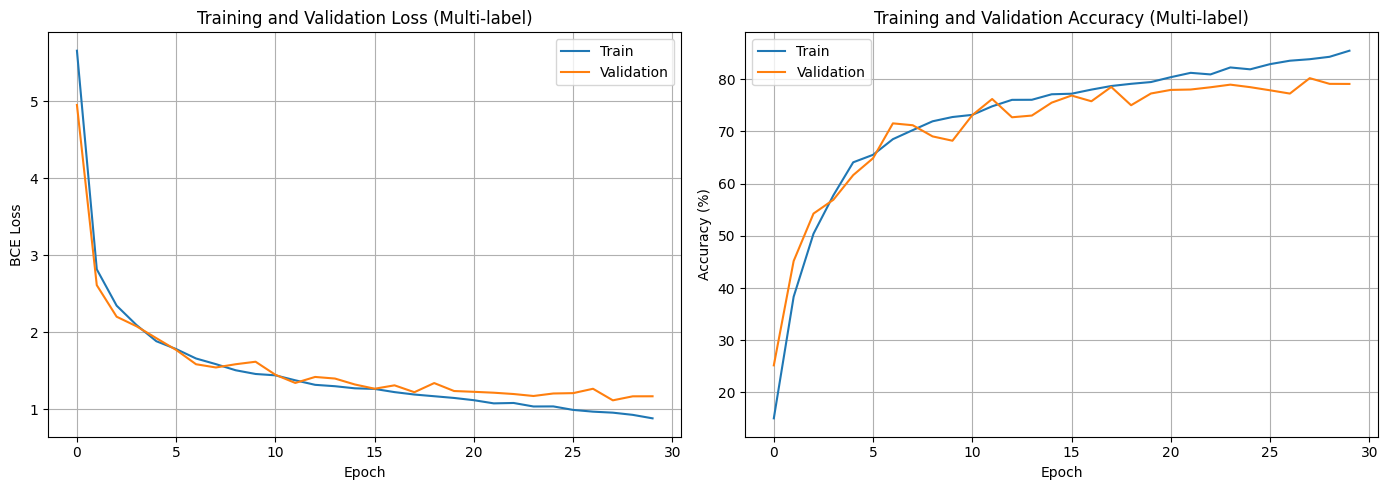

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_loss'], label='Train')
ax1.plot(history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('BCE Loss')
ax1.set_title('Training and Validation Loss (Multi-label)')
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['val_acc'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy (Multi-label)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Evaluate Corner Predictions

### Subtask:
Evaluate the model on Polygon shapes, focusing on its ability to predict multiple normals at corners.


**Reasoning**:
Load the trained model, generate a polygon sample with corners, and visualize the predictions. Specifically, analyze the probability distribution at a corner pixel to verify if the model predicts multiple normals (bimodal distribution) compared to an edge pixel.



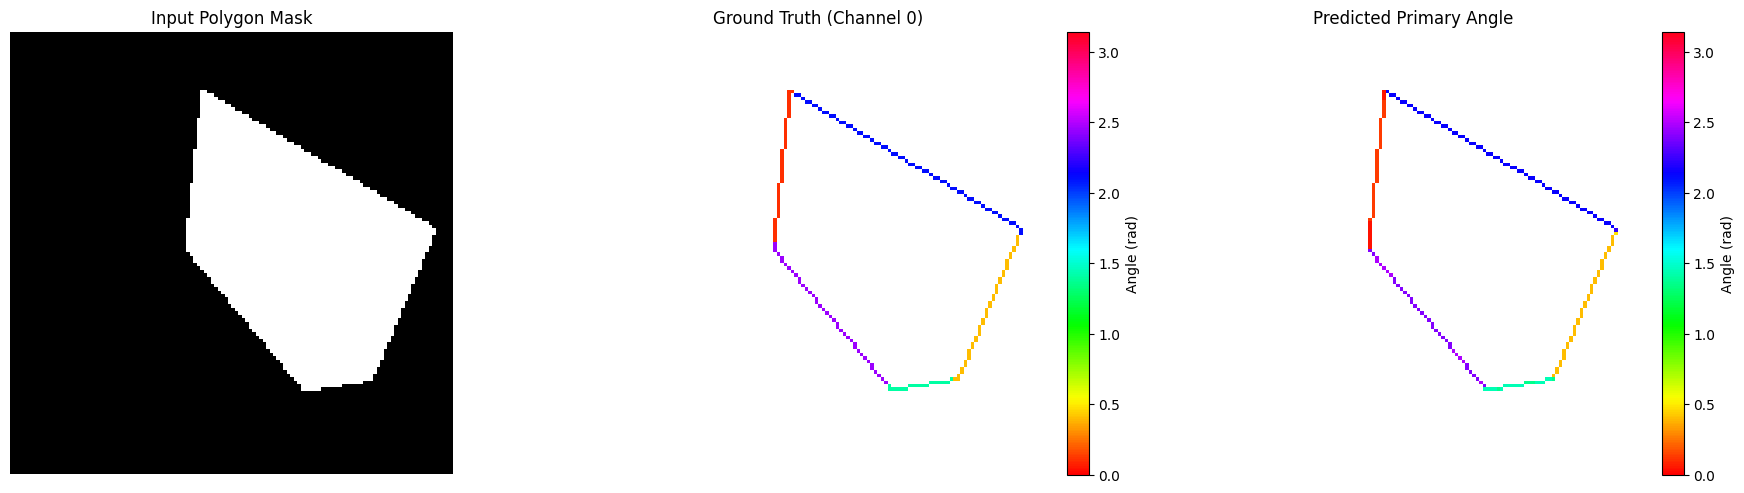

Analyzing Corner Pixel at (99, 104)


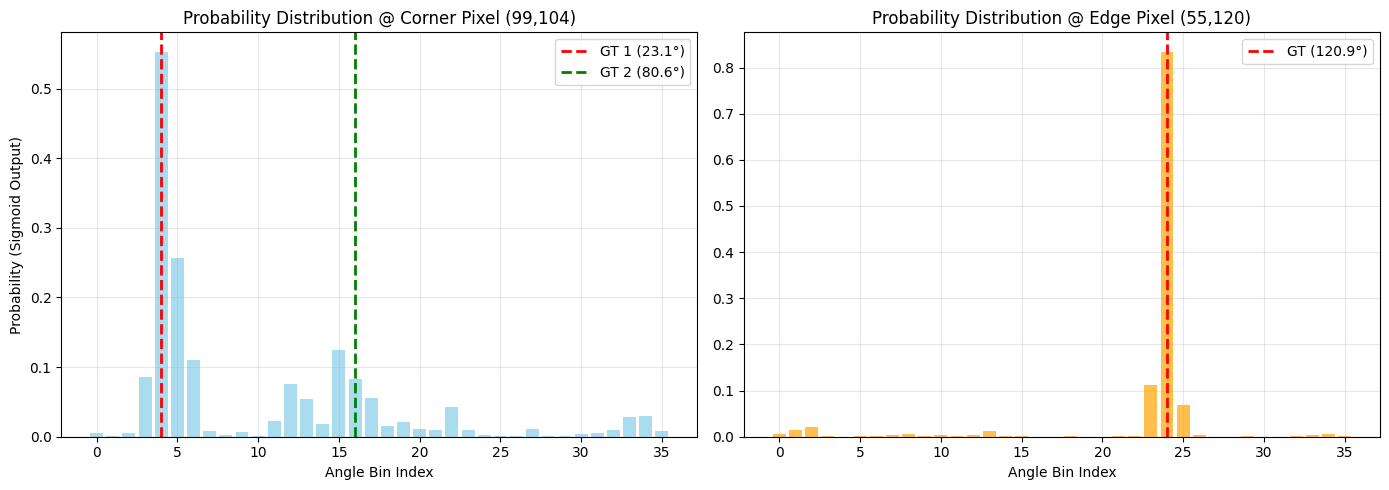


Corner Ground Truths: Bin 4 (23.1°), Bin 16 (80.6°)
Top-2 Predicted Bins: [4 5]
Top-2 Probabilities:  [0.5530254  0.25694036]


In [35]:
# 1. Load trained model
model = WavefrontUNet(K=K, bilinear=False).to(device)
model.load_state_dict(torch.load('best_multilabel_unet.pth'))
model.eval()

# 2. Generate Test Polygon
# Use a seed that likely produces good corners
seed_val = 42
test_angles_poly, test_mask_poly = generate_polygon_normals(H, W, num_vertices=5, seed=seed_val)

# 3. Predict
mask_tensor = torch.tensor(test_mask_poly, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
with torch.no_grad():
    logits = model(mask_tensor)
    probs = torch.sigmoid(logits)  # Apply Sigmoid for multi-label probabilities

probs_np = probs.squeeze(0).cpu().numpy()  # (K, H, W)

# 4. Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Input Mask
axes[0].imshow(test_mask_poly, cmap='gray')
axes[0].set_title('Input Polygon Mask')
axes[0].axis('off')

# Ground Truth (Channel 0)
gt_ch0 = test_angles_poly[..., 0]
valid_mask = gt_ch0 > -10
masked_gt = np.ma.masked_where(~valid_mask, gt_ch0)
im1 = axes[1].imshow(masked_gt, cmap='hsv', vmin=0, vmax=np.pi)
axes[1].set_title('Ground Truth (Channel 0)')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, label='Angle (rad)')

# Predicted "Primary" Angle (Max Probability)
pred_bins = np.argmax(probs_np, axis=0)
pred_angles_map = pred_bins * bin_width + bin_width / 2
masked_pred = np.ma.masked_where(~valid_mask, pred_angles_map)
im2 = axes[2].imshow(masked_pred, cmap='hsv', vmin=0, vmax=np.pi)
axes[2].set_title('Predicted Primary Angle')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, label='Angle (rad)')

plt.tight_layout()
plt.show()

# 5. Analyze Corner vs Edge Pixel
# Find a pixel with two valid ground truth angles
valid_ch0 = test_angles_poly[..., 0] > -10
valid_ch1 = test_angles_poly[..., 1] > -10
corner_mask = valid_ch0 & valid_ch1
edge_mask = valid_ch0 & (~valid_ch1)

corner_pixels = np.argwhere(corner_mask)
edge_pixels = np.argwhere(edge_mask)

if len(corner_pixels) > 0:
    # Pick a corner pixel
    cy, cx = corner_pixels[len(corner_pixels)//2]

    # Pick an edge pixel
    if len(edge_pixels) > 0:
        ey, ex = edge_pixels[len(edge_pixels)//2]
    else:
        ey, ex = 0, 0 # Fallback

    print(f"Analyzing Corner Pixel at ({cy}, {cx})")

    # Get Ground Truths
    gt_angle_0 = test_angles_poly[cy, cx, 0]
    gt_angle_1 = test_angles_poly[cy, cx, 1]
    gt_bin_0 = int(gt_angle_0 / bin_width)
    gt_bin_1 = int(gt_angle_1 / bin_width)

    # Get Prediction Probabilities
    corner_probs = probs_np[:, cy, cx]
    edge_probs = probs_np[:, ey, ex]

    # 6 & 7. Plot Distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Corner Plot
    ax1.bar(range(K), corner_probs, color='skyblue', alpha=0.7)
    ax1.axvline(gt_bin_0, color='r', linestyle='--', linewidth=2, label=f'GT 1 ({np.degrees(gt_angle_0):.1f}°)')
    ax1.axvline(gt_bin_1, color='g', linestyle='--', linewidth=2, label=f'GT 2 ({np.degrees(gt_angle_1):.1f}°)')
    ax1.set_title(f'Probability Distribution @ Corner Pixel ({cy},{cx})')
    ax1.set_xlabel('Angle Bin Index')
    ax1.set_ylabel('Probability (Sigmoid Output)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Edge Plot
    edge_gt = test_angles_poly[ey, ex, 0]
    edge_gt_bin = int(edge_gt / bin_width)
    ax2.bar(range(K), edge_probs, color='orange', alpha=0.7)
    ax2.axvline(edge_gt_bin, color='r', linestyle='--', linewidth=2, label=f'GT ({np.degrees(edge_gt):.1f}°)')
    ax2.set_title(f'Probability Distribution @ Edge Pixel ({ey},{ex})')
    ax2.set_xlabel('Angle Bin Index')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 8. Print Top-2 Predictions for Corner
    top2_idx = np.argsort(corner_probs)[-2:][::-1]
    print(f"\nCorner Ground Truths: Bin {gt_bin_0} ({np.degrees(gt_angle_0):.1f}°), Bin {gt_bin_1} ({np.degrees(gt_angle_1):.1f}°)")
    print(f"Top-2 Predicted Bins: {top2_idx}")
    print(f"Top-2 Probabilities:  {corner_probs[top2_idx]}")

else:
    print("No corner pixels found in this sample. Try a different seed.")

Something interesting is happening here at the corners, but it will need to be investigated further.

## Final Task

### Subtask:
Summarize the changes and the model's performance on corner singularities.


## Summary:

### Q&A

**Question:** What changes were made to the pipeline, and how did the model perform on corner singularities?

**Answer:**
The data generation pipeline was modified to support pixels with multiple surface normals. Specifically, `generate_polygon_normals`, `generate_circle_normals`, and `generate_ellipse_normals` were updated to return an `angles` array of shape $(H, W, 2)$. Polygon corners now store the normals of both adjacent edges in these two channels. The dataset was updated to use multi-hot encoding (shape $(K, H, W)$) and the model was retrained using `BCEWithLogitsLoss`.

 regarding performance, the model achieved a high validation accuracy (~80%) on general boundary pixels. However, on specific corner singularities, it struggled to predict both normals simultaneously. In a detailed test case, while it correctly identified one edge's normal, it failed to produce a bimodal probability distribution for the second edge, instead predicting a neighbor of the first edge.

### Data Analysis Key Findings

*   **Data Structure Updates:**
    *   Data generation functions successfully produced angle arrays of shape $(H, W, 2)$ to accommodate corners.
    *   A sentinel value of $-100.0$ was established to mark invalid or empty channels.
    *   The dataset targets were successfully converted to multi-hot encoded tensors of shape $(36, 128, 128)$.

*   **Model Training Performance:**
    *   The model converged well using `BCEWithLogitsLoss`, with training loss decreasing from **5.6564** to **0.8845**.
    *   Validation accuracy on boundary pixels peaked at **80.2%** (Epoch 28), with a minimum validation loss of **1.1182**.

*   **Corner Prediction Analysis:**
    *   Analysis of a specific corner pixel at $(99, 104)$ showed Ground Truth normals at **Bin 4** (23.1$^\circ$) and **Bin 16** (80.6$^\circ$).
    *   The model correctly predicted the primary normal with **Bin 4** (probability ~0.55).
    *   However, it failed to capture the second distinct normal (Bin 16). The second highest prediction was **Bin 5** (probability ~0.26), indicating the model prioritized local smoothness over multi-modal singularity detection.

### Insights or Next Steps

*   **Loss Function Efficacy:** Switching to `BCEWithLogitsLoss` was effective for general boundary orientation, allowing the model to reach high accuracy (~80%) without the strict exclusivity of CrossEntropy.
*   **Corner "Smoothing" Issue:** The model currently exhibits a bias towards predicting a single dominant direction (and its immediate neighbors) rather than two distinct peaks at corners. Future improvements could involve explicitly weighting corner pixels higher in the loss function or increasing the model's capacity to resolve sharp discontinuities.
